<a href="https://colab.research.google.com/github/LSSTDESC/DifferentiableHOS/blob/main/notebooks/spectrum_for_cosmology.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pylab inline 
%load_ext autoreload
%autoreload 2
import tensorflow as tf
import numpy as np
import sys
sys.path.insert(0,'/Users/dl264294/Desktop/github/flowpm/')
sys.path.insert(0,'/Users/dl264294/Desktop/github/DifferentiableHOS/')
sys.path.insert(0,'/Users/dl264294/Desktop/github/DifferentiableHOS/')
#from flowpm.spectrum_for_cosmology import power_spectrum_for_cosmology
from flowpm.tfbackground import rad_comoving_distance, a_of_chi
from flowpm.cosmology import Cosmology, Planck15
from flowpm.tfpower import linear_matter_power
from DifferentiableHOS.angular_power_tf import measure_power_spectrum_tf
from flowpm.tfpower import linear_matter_power
from flowpm.raytracing import  lightcone, Born
import flowpm 
from flowpm.scipy.interpolate import interp_tf
import jax
import jax_cosmo as jc
import jax.numpy as np



Populating the interactive namespace from numpy and matplotlib


In [2]:
nc=[32,32,320]   # size of the cube, number of cells
plane_size=32                    # number of pixel for x and  y 
Boxsize=[200,200,2000]          # Physical size of the cube
field=5.
n_steps=10

In [3]:
def z2a(z):
    a=1/(1+z)
    return a

def a2z(a):
    z=(1/a)-1
    return z

In [5]:
@tf.function
def power_spectrum_for_cosmology(
              Omega_c,
              sigma8):
    cosmology=Planck15(Omega_c=Omega_c,sigma8=sigma8)
    a_s=z2a(tf.convert_to_tensor(1.00, dtype=tf.float32))
    r = tf.linspace(0.,2000,2)
    a=a_of_chi(cosmology,r)
    ds=rad_comoving_distance(cosmology,a_s)
    init_stages = tf.linspace(0.1, a[-1], 2)
    k = tf.constant(np.logspace(-4, 1, 256), dtype=tf.float32)
    pk = linear_matter_power(cosmology, k)
    pk_fun = lambda x: tf.cast(tf.reshape(interp_tf(tf.reshape(tf.cast(x, tf.float32), [-1]), k, pk), x.shape), tf.complex64)
    initial_conditions = flowpm.linear_field(nc,    
                                            Boxsize, 
                                             pk_fun,         
                                             batch_size=1)
    # Sample particles
    state = flowpm.lpt_init(cosmology,initial_conditions, 0.1)   
    # Evolve particles down to z=0
    final_state = flowpm.nbody(cosmology,state, init_stages, nc)         
    # Retrieve final density field
    state, lps_a, lps=lightcone(cosmology,final_state, a[::-1], 
                                  nc, 
                                    field*60/plane_size, plane_size)
    k_map=Born(lps_a,lps,ds,nc,Boxsize,plane_size,field,cosmology)
    k_map=tf.cast(k_map,dtype=tf.complex64)
    ell, power_spectrum=measure_power_spectrum_tf(k_map,field,plane_size)
    return  power_spectrum, k_map

In [6]:
@tf.function
def compute_jacobian(Omega_c, sigma8):
    Omega_c=tf.convert_to_tensor(Omega_c,dtype=tf.float32)
    sigma8=tf.convert_to_tensor(sigma8,dtype=tf.float32)
    params = tf.stack([Omega_c, sigma8])
    with tf.GradientTape() as tape:
         tape.watch(params)
         power_spectrum, kmap= power_spectrum_for_cosmology(
              params[0], params[1])
        # And we are actually going to try to compress the PS 
        # to avoid needing too much memory
         power_spectrum = power_spectrum[::2] # it should be of size 8
    return tape.jacobian(power_spectrum, params,
                         experimental_use_pfor=False)

In [7]:
jacobian = compute_jacobian(0.2589,0.8159)

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))


In [8]:
print(jacobian)

tf.Tensor(
[[3.9565255e-04 4.5626334e-09]
 [1.6449118e-09 5.1466536e-08]
 [5.8222458e-09 1.6374747e-08]
 [9.8206741e-09 8.7880485e-09]
 [1.1838878e-09 4.5008259e-09]
 [2.3592288e-09 4.5918402e-09]
 [2.8457163e-09 1.7826316e-09]
 [3.3651965e-10 1.3630757e-09]], shape=(8, 2), dtype=float32)


In [9]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

def plot_contours(fisher, pos,  nstd=1., ax=None, **kwargs):
  """
  Plot 2D parameter contours given a Hessian matrix of the likelihood
  """
  
  def eigsorted(cov):
    vals, vecs = linalg.eigh(cov)
    order = vals.argsort()[::-1]
    return vals[order], vecs[:, order]

  mat = fisher
  cov = np.linalg.inv(mat)
  sigma_marg = lambda i: np.sqrt(cov[i, i])

  if ax is None:
      ax = plt.gca()

  vals, vecs = eigsorted(cov)
  theta = degrees(np.arctan2(*vecs[:, 0][::-1]))

  # Width and height are "full" widths, not radius
  width, height = 2 * nstd * sqrt(vals)
  ellip = Ellipse(xy=pos, width=width,
                  height=height, angle=theta, **kwargs)

  ax.add_artist(ellip)
  sz = max(width, height)
  s1 = 1.5*nstd*sigma_marg(0)
  s2 = 1.5*nstd*sigma_marg(1)
  ax.set_xlim(pos[0] - s1, pos[0] + s1)
  ax.set_ylim(pos[1] - s2, pos[1] + s2)
  plt.draw()
  return ellip

In [10]:
cosmo_jax = jc.Planck15()
chi_jax = np.linspace(0, 2000,10)

In [11]:
jc.Planck15?

/Users/dl264294/.local/lib/python3.8/site-packages/jax/_src/lax/lax.py:6081: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


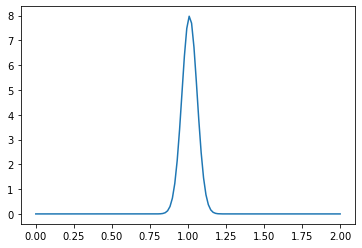

In [12]:
z = linspace(0,2,100)
pz = zeros_like(z)
pz[50] =1. 
nzs_s=jc.redshift.kde_nz(z, pz, bw=0.05)
# let's draw the nz on a new array of redshifts
zsamp = np.linspace(0,2,128)
plot(zsamp, nzs_s(zsamp))
nzs = [nzs_s]
probes = [ jc.probes.WeakLensing(nzs, sigma_e=0.26) ]
ell = np.logspace(1,4,8) # Defines a range of \ell
# And compute the data vector
cls = jc.angular_cl.angular_cl(cosmo_jax, ell, probes)

# we compute the covariance matrix using the tools from the Jax module
mu, cov = jc.angular_cl.gaussian_cl_covariance_and_mean(cosmo_jax, ell, probes, sparse=True);

In [13]:
params=np.array([0.2589,0.8159]) 

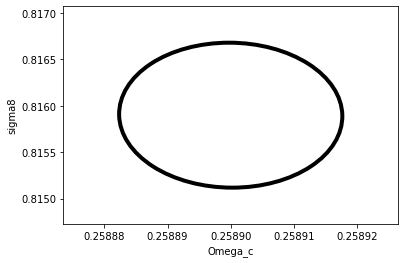

In [14]:
# Now we can compose the Fisher matrix:
F_2 = jc.sparse.dot(jacobian.numpy().T, jc.sparse.inv(cov), jacobian.numpy())
plot_contours(F_2, params, fill=False,color='black',lw=4);
figsize=(15,15)
xlabel('Omega_c')
ylabel('sigma8');